In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## Load and Refine Dataset

In [6]:
NUMERIC_COLUMNS = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'eFG%', 'TRB', 'AST', 'STL', 'BLK', 'PTS']
POSITIONS = ['PG', 'SG', 'SF', 'PF', 'C']

df = pd.read_csv('./nba_data_processed.csv')
df = df[df['Pos'].notna()]

# Keep only the columns needed
df = df[['Player', 'Pos', 'G', 'MP'] + NUMERIC_COLUMNS]

# Add efficiency columns
df['Offensive Efficiency'] = (df['FG'] + df['3P'] + df['2P'] + df['FT'] + df['PTS']) / 5
df['Defensive Efficiency'] = (df['TRB'] + df['STL'] + df['BLK']) / 3
df['Total Efficiency'] = (df['Offensive Efficiency'] + df['Defensive Efficiency']) / 2
df['Game Impact'] = (df['PTS'] + df['AST'] + df['TRB'] + df['STL'] + df['BLK']) / 5

# Normalize position values
def normalize(x):
    if ('-' in x):
        return x[0:x.find('-')]
    return x

df['Pos'] = df['Pos'].apply(normalize)

# Group up players that have played for multiple teams
df = df.groupby(['Player', 'Pos']).mean()
df = df.reset_index()

# The original columns are distributed in "value/game", so we convert them to "value/minute"
games_played = df['G']
minutes_played = df['MP'] * games_played

df = df.drop(['Player', 'G', 'MP'], axis=1)

for column in NUMERIC_COLUMNS:
    df[column] = (df[column] * games_played) / minutes_played

## Define prediction algorithms

In [21]:
RANDOM_STATE = 42

def prepare(x_cols, y_cols):
    global X, y, X_train, X_test, y_train, y_test
    
    X = df[x_cols]
    y = df[y_cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

def run_predictions():
    dt_prediction = decision_tree()
    knn_prediction = knn()
    lr_prediction = logistic_regression()

    print("Decision Tree:")
    print_results(dt_prediction)

    print("KNN:")
    print_results(knn_prediction)

    print("Logistic Regression:")
    print_results(lr_prediction)

def decision_tree():
    clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
    return predict(clf)

def knn():
    pipeline = make_pipeline(SimpleImputer(), KNeighborsClassifier(n_neighbors=5))
    return predict(pipeline)

def logistic_regression():
    pipeline = make_pipeline(SimpleImputer(), LogisticRegression(max_iter=1000))
    return predict(pipeline)

def predict(classifier):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    return y_pred

def print_results(y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
    precision = precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
    f1 = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
    
    print(f"Accuracy: {accuracy:.3f} | Recall: {recall:.3f} | Precision: {precision:.3f} | F1-Score: {f1:.3f}\n")

def plot_confusion_matrix(y_pred, title):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=POSITIONS)
    disp.ax_.set_title(title)

## Analyzing results

In [8]:
# Testing with all columns
prepare(x_cols=['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'eFG%', 'TRB', 'AST', 'STL', 'BLK', 'PTS'], y_cols='Pos')
run_predictions()

Decision Tree:
Accuracy: 0.445 | Recall: 0.445 | Precision: 0.484 | F1-Score: 0.451

KNN:
Accuracy: 0.473 | Recall: 0.473 | Precision: 0.494 | F1-Score: 0.481

Logistic Regression:
Accuracy: 0.564 | Recall: 0.564 | Precision: 0.653 | F1-Score: 0.541



In [9]:
# Removing 'PTS'
prepare(x_cols=['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'eFG%', 'TRB', 'AST', 'STL', 'BLK'], y_cols='Pos')
run_predictions()

Decision Tree:
Accuracy: 0.445 | Recall: 0.445 | Precision: 0.479 | F1-Score: 0.453

KNN:
Accuracy: 0.500 | Recall: 0.500 | Precision: 0.522 | F1-Score: 0.503

Logistic Regression:
Accuracy: 0.564 | Recall: 0.564 | Precision: 0.679 | F1-Score: 0.538



In [10]:
# Keeping only efficiency columns
prepare(x_cols=['Offensive Efficiency', 'Defensive Efficiency', 'Total Efficiency', 'Game Impact'], y_cols='Pos')
run_predictions()

Decision Tree:
Accuracy: 0.364 | Recall: 0.364 | Precision: 0.364 | F1-Score: 0.360

KNN:
Accuracy: 0.391 | Recall: 0.391 | Precision: 0.462 | F1-Score: 0.406

Logistic Regression:
Accuracy: 0.464 | Recall: 0.464 | Precision: 0.467 | F1-Score: 0.457



In [11]:
# Keeping only "Game Impact" columns without 'PTS'
prepare(x_cols=['TRB', 'AST', 'STL', 'BLK'], y_cols='Pos')
run_predictions()

Decision Tree:
Accuracy: 0.409 | Recall: 0.409 | Precision: 0.504 | F1-Score: 0.436

KNN:
Accuracy: 0.573 | Recall: 0.573 | Precision: 0.632 | F1-Score: 0.592

Logistic Regression:
Accuracy: 0.555 | Recall: 0.656 | Precision: 0.675 | F1-Score: 0.606



In [12]:
# Including '2P%' and '3P%'
prepare(x_cols=['TRB', 'AST', 'STL', 'BLK', '2P%', '3P%'], y_cols='Pos')
run_predictions()

Decision Tree:
Accuracy: 0.427 | Recall: 0.427 | Precision: 0.493 | F1-Score: 0.449

KNN:
Accuracy: 0.609 | Recall: 0.609 | Precision: 0.632 | F1-Score: 0.615

Logistic Regression:
Accuracy: 0.564 | Recall: 0.667 | Precision: 0.693 | F1-Score: 0.620



## Confusion Matrix

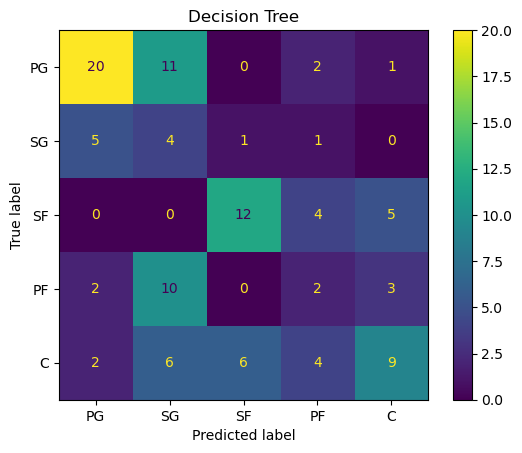

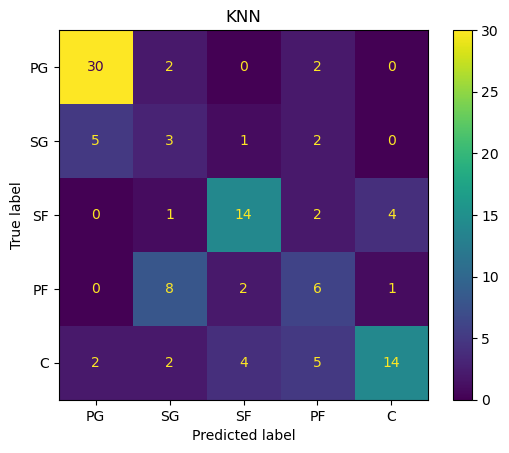

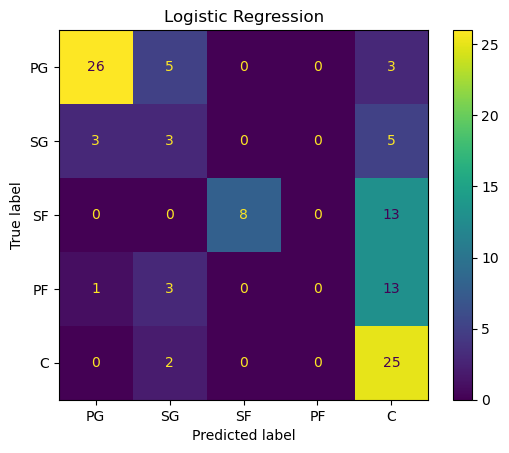

In [22]:
prepare(x_cols=['TRB', 'AST', 'STL', 'BLK', '2P%', '3P%'], y_cols='Pos')

plot_confusion_matrix(decision_tree(), "Decision Tree")
plot_confusion_matrix(knn(), "KNN")
plot_confusion_matrix(logistic_regression(), "Logistic Regression")